In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from prince import MCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Presentation

### [Zoo Dataset](https://archive.ics.uci.edu/dataset/111/zoo)

This is a showcase of usage of the K-Means clustering method applied to a purely categorical dataset - mainly binary data, except for leg count, which can be taken to be category-coded. The main purpose is to correctly categorize animals by type based on the 16 features in the dataset (`zoo-data.csv`). This is a toy example, but the workflow can be readily implemented on larger or real-world datasets. The list of features and 
their data type are as follow:
* hair: Boolean
* feathers: Boolean
* eggs: Boolean
* milk: Boolean
* airborne: Boolean
* aquatic: Boolean
* predator: Boolean
* toothed: Boolean
* backbone: Boolean
* breathes: Boolean
* venomous: Boolean
* fins: Boolean
* legs: Numeric (set of values {0, 2, 4, 5, 6, 8})
* tail: Boolean
* domestic: Boolean
* catsize: Boolean

*Whether the animal has the feature in question or not.*

The task consists of a classification of the animals into a cluster based on the features presented, and a-posteriori comparison with the actual type of the animal, presented in the file `zoo-labels.csv`. We can present the following two questions:
* How many groups, based on features, can be formed?
* Based on the clusters and the animals within, what names or classes are appropriate for each cluster?

# Data Cleaning

We have a convenient split of features and labels already. However, since this is a clustering problem, we will use the `type` column in the `zoo-labels.csv` file as validation.

In [2]:
# Data loading onto separate dataframes
X = pd.read_csv('zoo-data.csv', sep=';')
labels = pd.read_csv('zoo-labels.csv', sep=';')

# For later validation
df = pd.concat([X, labels], axis=1)

In [3]:
# Sneak peek at the data
X.head(2)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,yes,no,no,yes,no,no,yes,yes,yes,yes,no,no,4,no,no,yes
1,yes,no,no,yes,no,no,no,yes,yes,yes,no,no,4,yes,no,yes


In [4]:
labels.head(2)

,type,name
0,mammal,aardvark
1,mammal,antelope


In [5]:
# Full dataframe, for the error estimation.
df.head(2)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,name
0,yes,no,no,yes,no,no,yes,yes,yes,yes,no,no,4,no,no,yes,mammal,aardvark
1,yes,no,no,yes,no,no,no,yes,yes,yes,no,no,4,yes,no,yes,mammal,antelope


We perform the usual minimum checks to verify the data's integrity. We check for duplicates, nulls, and correct data types. We also confirm that boolean features only have two distinct values.

Usually we would perform the checks on `X`, out features dataframe. We will however take advantage of the fact that we have also the labels and perform a single check of all the available data, even though clustering only applies to the `X` dataframe.

In [6]:
print('Number of duplicates: ', df.duplicated(keep='first').sum())
print('Number of nulls :', (df.isnull().sum() + df.isna().sum()).sum())
df.nunique(), df.dtypes

Number of duplicates:  0
Number of nulls : 0


(hair          2
 feathers      2
 eggs          2
 milk          2
 airborne      2
 aquatic       2
 predator      2
 toothed       2
 backbone      2
 breathes      2
 venomous      2
 fins          2
 legs          6
 tail          2
 domestic      2
 catsize       2
 type          7
 name        100
 dtype: int64,
 hair        object
 feathers    object
 eggs        object
 milk        object
 airborne    object
 aquatic     object
 predator    object
 toothed     object
 backbone    object
 breathes    object
 venomous    object
 fins        object
 legs         int64
 tail        object
 domestic    object
 catsize     object
 type        object
 name        object
 dtype: object)

#### Fixing datatypes
We see that we have no booleans in the data, as they're all using yes/no instead of Python's `True` and `False`. We fix that right away.

In [7]:
for col in X.drop(columns=['legs']).columns:
    X[col].replace(to_replace={'yes': True, 'no': False}, inplace=True)
    X[col] = X[col].astype(bool)
X.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True
1,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True
2,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False
3,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True
4,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True


In [8]:
df = pd.concat([X, labels], axis=1)
X.dtypes

hair         bool
feathers     bool
eggs         bool
milk         bool
airborne     bool
aquatic      bool
predator     bool
toothed      bool
backbone     bool
breathes     bool
venomous     bool
fins         bool
legs        int64
tail         bool
domestic     bool
catsize      bool
dtype: object

Fixed!  
After changing the datatypes of the `object` columns, we follow up with an Exploratory Data Analysis.

# Exploratory Data Analysis (EDA)

We will start by checking which features present some degree of correlation. In this case, correlation can be taken to be co-occurrence given the type of data.

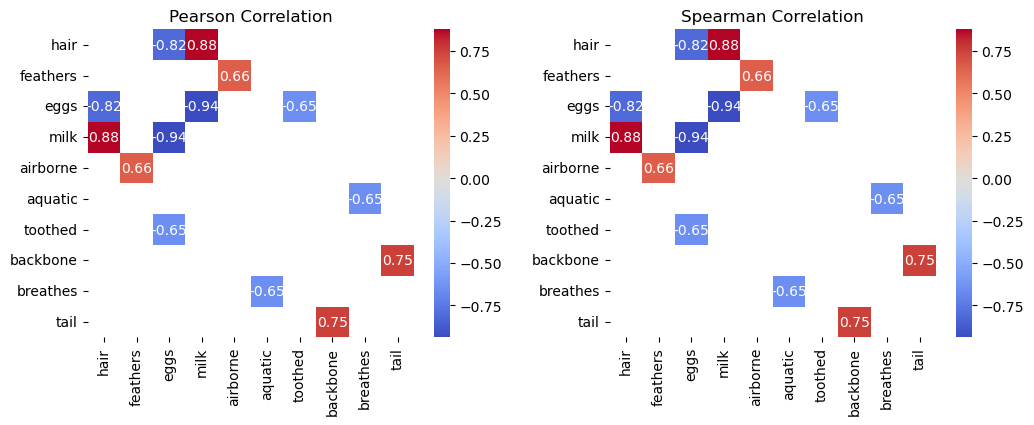

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), gridspec_kw={'wspace': 0.28})
corr_matrix1 = X.corr(method='pearson')
corr_matrix2 = X.corr(method='spearman')
thr = 0.65
corr_dummy1 = corr_matrix1[(abs(corr_matrix2) > thr) & (corr_matrix2 != 1)].dropna(thresh=1).dropna(thresh=1, axis=1)
corr_dummy2 = corr_matrix2[(abs(corr_matrix2) > thr) & (corr_matrix2 != 1)].dropna(thresh=1).dropna(thresh=1, axis=1)
sns.heatmap(corr_dummy1, cmap='coolwarm', annot=True, ax=axes[0]);
axes[0].set_title('Pearson Correlation')
axes[1].set_title('Spearman Correlation')
sns.heatmap(corr_dummy2, cmap='coolwarm', annot=True, ax=axes[1]);

We see that both correlations are equal. These makes total sense, as in this case a correlation between values pretty much is binary: Values are either the same - True/True or False/False - or opposite - True/False or False/True.

We now check the count of True instances for each feature to get an idea of the proportion of True to False.

In [10]:
X.drop(columns=['legs']).sum(axis=0)

hair        43
feathers    20
eggs        58
milk        41
airborne    24
aquatic     35
predator    55
toothed     60
backbone    82
breathes    79
venomous     7
fins        17
tail        75
domestic    13
catsize     44
dtype: int64

A visualization will help us greatly in this case. Before plotting though, we will have to take and transform the data to make it easier to plot. This new dataframe, which is an un-pivotted or long formatted version of our original dataframe, will help us with visualizations. This might not be convenient if working with datasets that are too big, but since we have the advantage of only ~100 observations, we will proceed with basically duplicating the data.

Two plots will help us get an idea of the proportion of True to False, both bar diagrams, but one of the stacked.

In [11]:
X_melted = X.drop(columns=['legs']).melt(var_name='Feature')

In [12]:
X_melted.head()

,Feature,value
0,hair,True
1,hair,True
2,hair,False
3,hair,True
4,hair,True


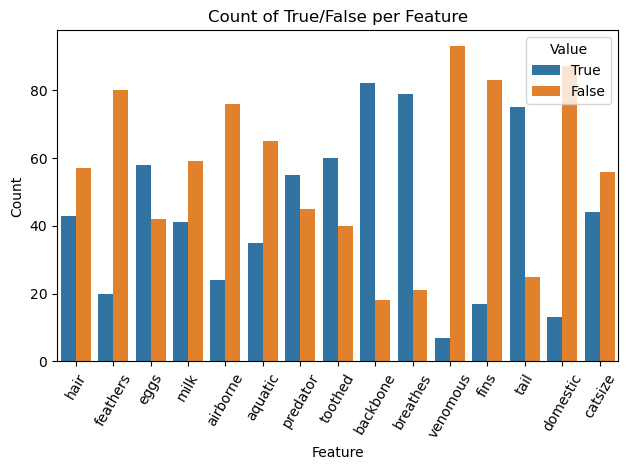

In [13]:
count_X = pd.DataFrame({
    'Feature': X.drop(columns=['legs']).columns,
    'True': X.drop(columns=['legs']).sum(axis=0),
    'False': len(X.drop(columns=['legs'])) - X.drop(columns=['legs']).sum(axis=0)
})

count_X_melted = count_X.melt(id_vars='Feature', value_vars=['True', 'False'], 
                                var_name='Value', value_name='Count')
sns.barplot(x='Feature', y='Count', hue='Value', data=count_X_melted)
plt.title('Count of True/False per Feature')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

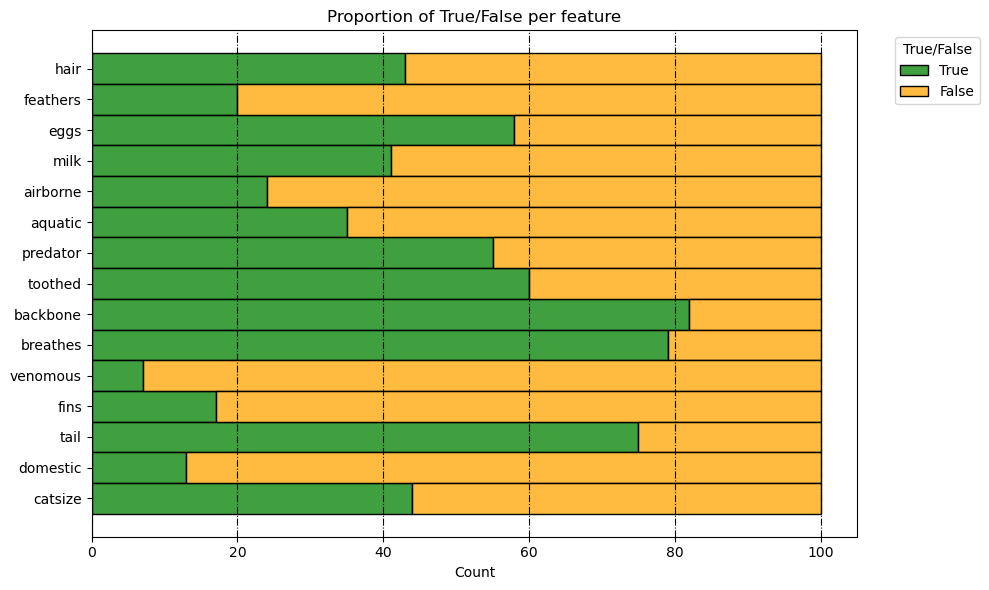

In [14]:
# Another way of presenting the information of the previous plot.
plt.figure(figsize=(10, 6))
sns.histplot(data=X_melted, y='Feature', hue='value', multiple='stack', palette=['orange', 'green'])
plt.xlabel('Count')
plt.ylabel('')
plt.title('Proportion of True/False per feature')
plt.legend(['True', 'False'], title='True/False', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='x', linestyle='-.', color='k')
plt.show()

We appreciate higher corelations, either positive or negative, between the features *eggs*-*milk*-*hair*, between *backbone*-*tail*, between *feathers*-*airborne*, and between *aquatic*-*breathes*. There certainly are other correlations, but these seem like the most noteworthy. To take advantage of these apparent relations between features, we will apply a dimensionality reduction strategy.  
We also see clear trends in the True/False prevalence in certain features, such as with venomous animals (*venomous*) and (*domestic*), for both of which most observations are False, hinting at the fact that most domestic animals are not venomous.

Lastly and as a sort of spoiler or cheat, we take a look at the distribution of the `type` column in the `labels` dataset. We usually don't have this information, and we will not make use of it for the clustering.

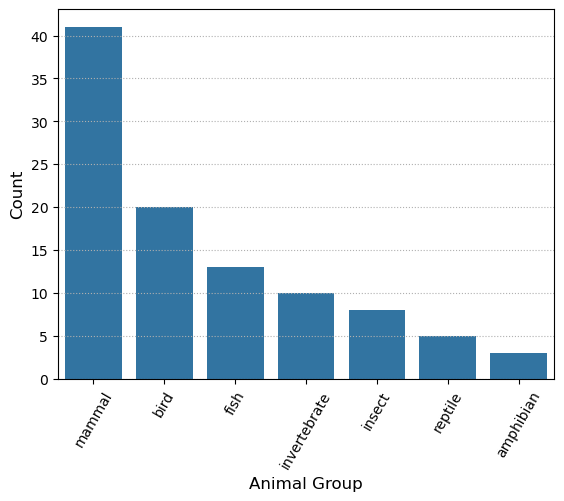

In [15]:
sorted_vals = labels.groupby(by=['type']).nunique().sort_values(by=['name'], ascending=False)
sns.barplot(x=sorted_vals.index,
            y=sorted_vals['name'].to_numpy());
plt.xticks(rotation=60)
plt.xlabel('Animal Group', fontsize=12);
plt.ylabel('Count', fontsize=12);
plt.grid(linestyle=':', axis='y');

Mammals dominate the dataset, with amphibians being the rarest.

# Clustering

### Data preprocessing: MCA
We apply a Multiple Correspondence Analysis (MCA), which is akin to a Principal Component Analysis (PCA), but tailored to qualitative data; it is a dimensionality reduction technique that looks at the coincidence between two or more features. For example, if two features have a lot of observations in which both are True, they will be a good candidate to form a component (correspondence doesn't mean two features have the same value, they can be opposite). The [implementation of MCA](https://maxhalford.github.io/prince/mca/) we're using already pre-applies one-hot encoding to categorical features, so we're skipping this step. However, it is usually a good idea to keep this in mind when working with categorical data.

With this dimensionality reduction technique, we can more easily work with this dataset while at the same time dealing with the *curse of dimensionality* in a fashionable way, since we will apply K-Means clustering and the components are scaled to a 0 - 1 scale.

In [16]:
n = 15
mca = MCA(n_components=n,
          n_iter=20,
          random_state=42)
X_reduced = mca.fit_transform(X)
X_reduced.columns = ['Comp_{}'.format(i) for i in range(1,n+1)]

Once again we take advantage of the small dataset and we calculate a big number of components (`n = 15`) to check how
much of the variance we can explain. We're aiming at ~80% for a good enough degree of confidence in the
correctness of the clustering, even though in a real setting we probably never really know how well we did.

In [17]:
# Summary table of the eigenvalues and the % of variance they account for.
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.328,26.24%,26.24%
1,0.236,18.87%,45.11%
2,0.175,14.02%,59.13%
3,0.087,6.93%,66.06%
4,0.075,6.01%,72.07%
5,0.063,5.02%,77.10%
6,0.050,4.02%,81.11%
7,0.044,3.52%,84.63%
8,0.042,3.33%,87.96%


We now plot the percentage of variance as a function of the number of components that we choose to use, ordered from the most to the least contribution. Considering our ~80% goal, we take the first 7 principal components.

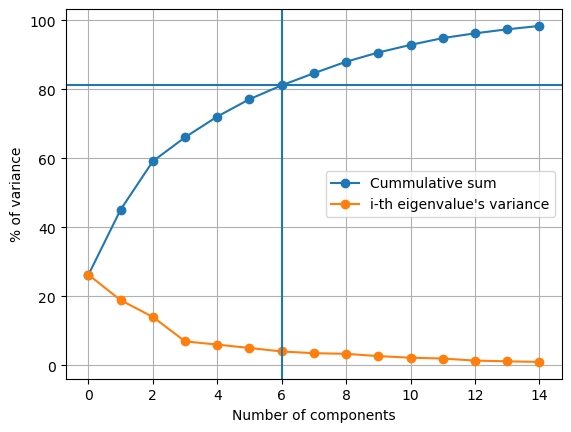

In [18]:
plt.plot(np.arange(0, len(mca.percentage_of_variance_)),
         np.cumsum(mca.percentage_of_variance_),
         marker='o',
         label='Cummulative sum');
plt.plot(np.arange(0, len(mca.percentage_of_variance_)),
         mca.percentage_of_variance_,
         marker='o',
         label='i-th eigenvalue\'s variance');
plt.xlabel('Number of components')
plt.ylabel('% of variance')
plt.axvline(6)
plt.axhline(np.sum(mca.percentage_of_variance_[:7]))
plt.grid()
plt.legend()

In [19]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.328,26.24%,26.24%
1,0.236,18.87%,45.11%
2,0.175,14.02%,59.13%
3,0.087,6.93%,66.06%
4,0.075,6.01%,72.07%
5,0.063,5.02%,77.10%
6,0.050,4.02%,81.11%
7,0.044,3.52%,84.63%
8,0.042,3.33%,87.96%


The choice of how many components to use is case-specific. That said, the idea is to strike a good balance between as low as possible a number of components, gaining calculation efficiency, and not losing too much interpretability in the process. As said, our aim of ~80% of variance accounted for means we need 7 components (0 through 6).

This step is not really needed as we already have the information, but we recalculate the MCA up to the seventh component.

In [20]:
mca = MCA(n_components=7,
          n_iter=20,
          random_state=42)
X_reduced = mca.fit_transform(X)
X_reduced.columns = ['Comp_{}'.format(i) for i in range(1,8)]
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.328,26.24%,26.24%
1,0.236,18.87%,45.11%
2,0.175,14.02%,59.13%
3,0.087,6.93%,66.06%
4,0.075,6.01%,72.07%
5,0.063,5.02%,77.10%
6,0.050,4.02%,81.11%


The composition of each of the seven components is shown next. Remember that the implementation of MCA we're using applies one-hot encoding to the data, so there are more columns than originally. Summing to the right (horizontally), we check that all columns add up to 1 (100%).

In [21]:
mca.column_contributions_.T.style.format('{:.2%}')

,hair_False,hair_True,feathers_False,feathers_True,eggs_False,eggs_True,milk_False,milk_True,airborne_False,airborne_True,aquatic_False,aquatic_True,predator_False,predator_True,toothed_False,toothed_True,backbone_False,backbone_True,breathes_False,breathes_True,venomous_False,venomous_True,fins_False,fins_True,legs_0,legs_2,legs_4,legs_5,legs_6,legs_8,tail_False,tail_True,domestic_False,domestic_True,catsize_False,catsize_True
0,5.79%,7.68%,0.67%,2.66%,9.16%,6.63%,7.00%,10.08%,0.98%,3.09%,1.00%,1.86%,0.00%,0.00%,6.34%,4.23%,4.36%,0.96%,2.74%,0.73%,0.07%,0.89%,0.07%,0.33%,1.16%,0.83%,7.24%,0.42%,2.51%,0.32%,1.51%,0.50%,0.09%,0.62%,3.29%,4.19%
1,0.47%,0.62%,1.68%,6.72%,0.01%,0.01%,0.03%,0.04%,2.75%,8.69%,4.20%,7.80%,3.18%,2.60%,4.39%,2.93%,0.13%,0.03%,12.00%,3.19%,0.03%,0.38%,2.74%,13.37%,12.43%,6.37%,0.03%,0.20%,1.27%,0.09%,0.06%,0.02%,0.17%,1.17%,0.09%,0.11%
2,1.34%,1.77%,2.97%,11.89%,0.34%,0.24%,0.12%,0.18%,0.43%,1.36%,0.54%,1.01%,0.07%,0.06%,0.19%,0.12%,18.50%,4.06%,0.03%,0.01%,0.22%,2.97%,0.53%,2.60%,0.50%,9.63%,0.64%,0.99%,13.77%,1.85%,15.40%,5.13%,0.00%,0.01%,0.23%,0.29%
3,0.23%,0.30%,0.34%,1.36%,0.23%,0.17%,0.01%,0.01%,0.33%,1.04%,0.19%,0.36%,14.88%,12.17%,2.01%,1.34%,0.38%,0.08%,0.33%,0.09%,0.02%,0.25%,1.04%,5.06%,4.27%,0.45%,0.45%,4.24%,3.81%,20.99%,0.05%,0.02%,2.19%,14.68%,2.93%,3.73%
4,0.00%,0.00%,0.00%,0.00%,0.52%,0.38%,0.13%,0.19%,0.07%,0.21%,0.58%,1.08%,0.18%,0.15%,0.06%,0.04%,0.02%,0.00%,0.11%,0.03%,2.65%,35.19%,0.01%,0.05%,1.58%,0.00%,0.86%,25.08%,0.36%,22.84%,3.04%,1.01%,0.46%,3.09%,0.01%,0.02%
5,0.06%,0.08%,0.03%,0.14%,0.14%,0.10%,0.00%,0.01%,0.16%,0.51%,0.02%,0.03%,1.46%,1.19%,0.02%,0.02%,0.00%,0.00%,2.31%,0.61%,0.07%,0.88%,0.08%,0.40%,0.24%,0.08%,0.01%,38.83%,9.16%,6.20%,0.14%,0.05%,4.73%,31.66%,0.26%,0.33%
6,0.42%,0.56%,0.01%,0.03%,0.30%,0.21%,0.00%,0.00%,0.50%,1.59%,0.31%,0.57%,2.32%,1.90%,0.88%,0.59%,0.88%,0.19%,0.48%,0.13%,2.53%,33.60%,0.34%,1.68%,0.60%,0.00%,0.00%,12.27%,0.06%,20.10%,1.67%,0.56%,0.74%,4.96%,3.97%,5.06%


In [22]:
mca.column_contributions_.T.sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
dtype: float64

Next we're gonna take a look at the table we saw before, but as bar plots. This will help us understand which features are most relevant for each principal component. That said, we will only check the 10 most important features for each component, as the visualization would be too overloaded otherwise.

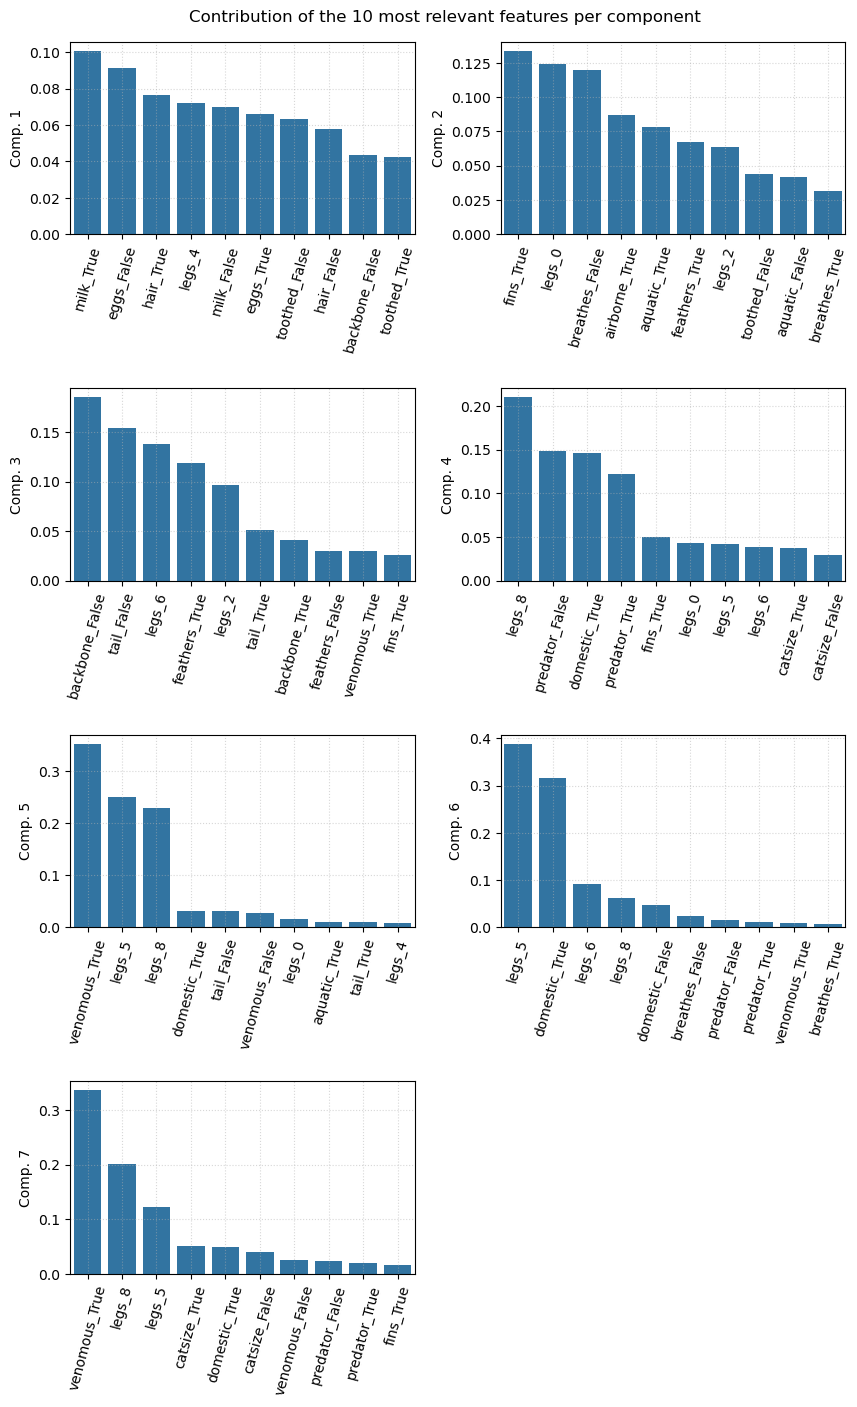

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(10, 16), gridspec_kw={'hspace':0.8, 'wspace':0.25})
fig.suptitle('Contribution of the 10 most relevant features per component', y=0.9)

for i, col in enumerate(list(mca.column_contributions_.columns)):
    vals = mca.column_contributions_[col].sort_values(ascending=False)[:10]
    row, col_pos = divmod(i, 2)
    sns.barplot(x=vals.index, y=vals, ax=axes[row, col_pos])
    axes[row, col_pos].tick_params(labelrotation=75, axis='x')
    axes[row, col_pos].set_xlabel('')
    axes[row, col_pos].set_ylabel('Comp. {:d}'.format(i+1))
    axes[row, col_pos].grid(linestyle=':', alpha=0.5)

axes[3, 1].axis('off')

plt.show()


Given other data, we might have been able to give each component an interpretation by studying the features' proportion within. In this case, there doesn't seem to be much to interpret, but we do notice features with repeated high percentages in some of the components (*legs_8* for example).

### K-Means clustering in the components' (MCA) space

We will apply a K-Means clustering due to its easiness of use, efficiency, and effectivenes. We will use regular Euclidean distances for cluster determination, because the data is in a 0 - 1 scale and the proportion of features:observations is good (7 components to 100 observations).

To choose a convenient number of clusters, we will use four metrics: *Inertia* using the elbow method, *Silhouette coefficient* but only through the coefficient's value and not with the plot, *Calinski-Harabasz* and finally *Davies-Bouldin*. After clustering, we will assign each animal to a cluster and try to label the clusters.

In [24]:
# After 8 clusters, scores continue to worsen monotonically.
inertias = list()
clusters = list()
for n in range(3, 9):
    kmc = KMeans(n_clusters=n, random_state=42, n_init=20, max_iter=100, verbose=1)
    clusters.append(kmc.fit_predict(X_reduced))
    inertias.append(kmc.inertia_)

Initialization complete
Iteration 0, inertia 76.91100797137595.
Iteration 1, inertia 56.75190174506408.
Iteration 2, inertia 54.73618084393391.
Iteration 3, inertia 54.20144250934421.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 78.2252278462824.
Iteration 1, inertia 57.5312484036011.
Iteration 2, inertia 56.162871619276906.
Iteration 3, inertia 56.095177060612315.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 79.25508967047362.
Iteration 1, inertia 55.955197390889865.
Iteration 2, inertia 54.444337087882815.
Iteration 3, inertia 54.16121160811201.
Iteration 4, inertia 53.98938915900321.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 63.465054619418154.
Iteration 1, inertia 53.79802971616931.
Iteration 2, inertia 53.757897271097164.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 70.20313568610973.
Iteration 1,

We use a projection onto a 2D space for visualization of the clusters by applying [t-SNE](https://jmlr.org/papers/v9/vandermaaten08a.html) to reduce the data to two dimensions. This is somewhat akin to dimensionally reducing the already dimensionally reduced data for the purpose of obtaining an easy visualization. While at it, we also calculate the other metrics appart from Inertia that we intend to use to evaluate the clustering process. These are stored as lists, for each of the different number of clusters tested.

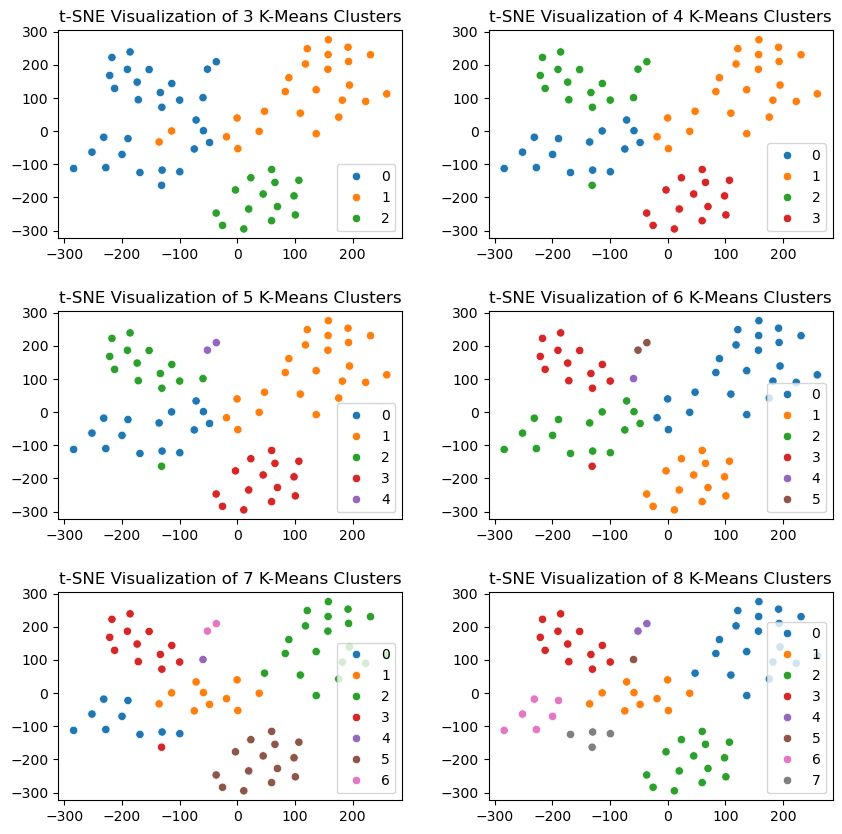

In [25]:
from sklearn.metrics import (silhouette_score,
                            calinski_harabasz_score,
                            davies_bouldin_score)
from sklearn.manifold import TSNE

# Scores for each number of clusters
s_score = list()
ch_score = list()
db_score = list()

# 2D space projection of the clustered data

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_reduced)

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,10), gridspec_kw={'wspace':0.25, 'hspace':0.35})
for num, cluster in enumerate(clusters):
    row, col = divmod(num, 2)
    # Scores
    s_score.append(silhouette_score(X_reduced, cluster))
    ch_score.append(calinski_harabasz_score(X_reduced, cluster))
    db_score.append(davies_bouldin_score(X_reduced, cluster))
    # Viz
    sns.scatterplot(ax=axes[row, col], x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster, palette='tab10')    
    axes[row, col].set_title("t-SNE Visualization of {:d} K-Means Clusters".format(len(np.unique(cluster))))

### Elbow-method to determine the best number of clusters.
We apply the Elbow Method to the Inertia plot to determine the best number of clusters. However, Inertia has a characteristic that's cumbersome: it monotonically decreases with the number of clusters. Once again we need to strike a balance between a low number of clusters and a low-enough Inertia, which is another form of the usual dilemma of the bias-variance trade-off. This balance, in our opinion, is found with 6 clusters, but as we mentioned, there are other metrics that help solidify this choice of clusters.

In [26]:
x_vals = list(range(3, 9))

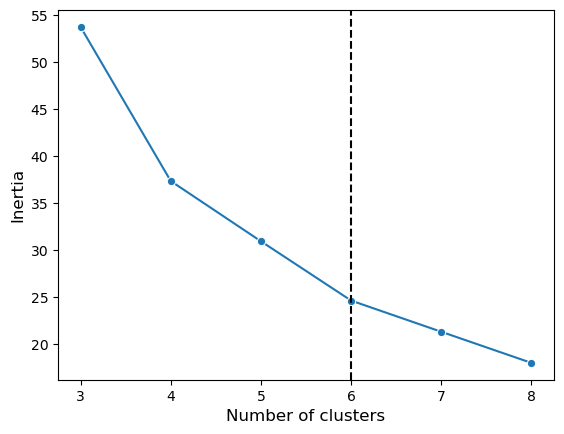

In [27]:
sns.lineplot(x=x_vals, y=inertias, marker='o')
plt.axvline(6, color='k', linestyle='--')
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12);

### Verifying metrics for different number of clusters

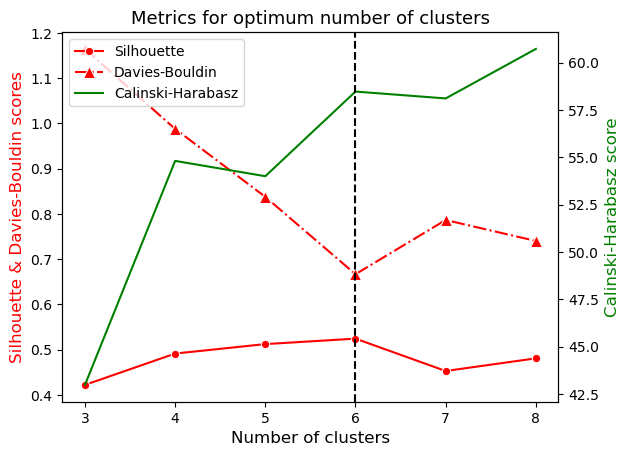

In [28]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
s_plot = sns.lineplot(ax=ax, x=x_vals, y=s_score, color='red', marker='o', label='Silhouette', legend=False)
db_plot = sns.lineplot(ax=ax, x=x_vals, y=db_score, color='red', marker='^', linestyle='-.', markersize=9, label='Davies-Bouldin', legend=False)
ch_plot = sns.lineplot(ax=ax2, x=x_vals, y=ch_score, color='green', label='Calinski-Harabasz', legend=False)

lines, labels = np.concatenate([ax.get_legend_handles_labels(), ax2.get_legend_handles_labels()], axis=1)

plt.title('Metrics for optimum number of clusters', fontsize=13)
ax.set_ylabel('Silhouette & Davies-Bouldin scores', color='red', fontsize=12)
ax2.set_ylabel('Calinski-Harabasz score', color='green', fontsize=12)
ax.set_xlabel('Number of clusters', fontsize=12)

plt.axvline(6, color='k', linestyle='--')
plt.legend(lines, labels);

### Evaluation metrics meaning summary
* Calinksi-Harabasz: The Calinski Harabasz index is the quotient between inter-cluster dispersion and intra cluster average dispersion, so the higher the value, the more compact the cluster ([source](https://www.analyticslane.com/2023/06/16/identificar-el-numero-de-clusteres-con-calinski-harabasz-en-k-means-e-implementacion-en-python/)).
* Davies-Bouldin: It's the quotient of average distance of each element to its cluster centroid and distance between centroids of different clusters (inter centroid distance). In other words, it's a measure of the distance between clusters. The distance between each element and its centroid can be any distance $L_i$ with $i\in {0, 1... n}$.
* Silhouette score: A measurement of the similarity between a data point and the other that belong to the same cluster, versus the similarity with members of other clusters. The range is -1 to +1, and we look for higher positive values of the score.

Based on the previous metrics, we reinforce our notion that **6** clusters is an ideal choice in terms of cluster definition, between-cluster separation, and compactness of clusters.

### Retraining with optimum number of clusters

In [29]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20, max_iter=100)
kmeans.fit_predict(X_reduced)
kmeans_labels = kmeans.labels_

We now assign each animal to a cluster as a new column, also adding the name of the animal to better inform our naming of each cluster; yes, the name is not really information we would have in a normal setting either, so it's a little bit of cheating. We work on the original `X` dataframe, and will then compare with the actual groups from the `type` column of the `df` dataframe.

In [33]:
df['cluster'] = kmeans_labels
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,name,cluster
0,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal,aardvark,0
1,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,mammal,antelope,0
2,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,fish,bass,2
3,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal,bear,0
4,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,mammal,boar,0


In [34]:
X['cluster'] = kmeans_labels
X.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,cluster
0,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,0
1,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,0
2,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,2
3,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,0
4,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,0


## Definition of the meaning of each cluster
We will now attempt to define what each cluster corresponds to without using the `type` column. To achieve this, we will go the easy route, and since the `X` dataframe with the `name` column is the same as our `df` dataframe without the `type` column, we will simply drop `type` from `df` and call it `df2`.

In [35]:
df2 = df.drop(columns='type')

And we now display which observations correspond to each cluster.

In [36]:
from IPython.display import display
for c in df2.cluster.unique():
    display(df2[df2.cluster == c])

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
0,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,aardvark,0
1,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,antelope,0
3,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,bear,0
4,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,boar,0
5,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,buffalo,0
6,True,False,False,True,False,False,False,True,True,True,False,False,4,True,True,True,calf,0
9,True,False,False,True,False,False,False,True,True,True,False,False,4,False,True,False,cavy,0
10,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,cheetah,0
17,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,deer,0
22,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,elephant,0


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
2,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,bass,2
7,False,False,True,False,False,True,False,True,True,False,False,True,0,True,True,False,carp,2
8,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,catfish,2
12,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,chub,2
18,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,True,dogfish,2
19,False,False,False,True,False,True,True,True,True,True,False,True,0,True,False,True,dolphin,2
25,False,False,True,False,False,True,True,True,True,True,False,False,4,False,False,False,frog,2
33,False,False,True,False,False,True,False,True,True,False,False,True,0,True,False,False,haddock,2
37,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,herring,2
51,False,False,True,False,False,True,True,True,True,True,False,False,4,True,False,False,newt,2


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
11,False,True,True,False,True,False,False,False,True,True,False,False,2,True,True,False,chicken,1
16,False,True,True,False,True,False,True,False,True,True,False,False,2,True,False,False,crow,1
20,False,True,True,False,True,False,False,False,True,True,False,False,2,True,True,False,dove,1
21,False,True,True,False,True,True,False,False,True,True,False,False,2,True,False,False,duck,1
23,False,True,True,False,True,False,False,False,True,True,False,False,2,True,False,True,flamingo,1
32,False,True,True,False,True,True,True,False,True,True,False,False,2,True,False,False,gull,1
36,False,True,True,False,True,False,True,False,True,True,False,False,2,True,False,False,hawk,1
40,False,True,True,False,False,False,True,False,True,True,False,False,2,True,False,False,kiwi,1
42,False,True,True,False,True,False,False,False,True,True,False,False,2,True,False,False,lark,1
55,False,True,True,False,False,False,False,False,True,True,False,False,2,True,False,True,ostrich,1


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
13,False,False,True,False,False,False,True,False,False,False,False,False,0,False,False,False,clam,3
14,False,False,True,False,False,True,True,False,False,False,False,False,4,False,False,False,crab,3
15,False,False,True,False,False,True,True,False,False,False,False,False,6,False,False,False,crayfish,3
24,False,False,True,False,False,False,False,False,False,True,False,False,6,False,False,False,flea,3
29,False,False,True,False,True,False,False,False,False,True,False,False,6,False,False,False,gnat,3
38,True,False,True,False,True,False,False,False,False,True,True,False,6,False,True,False,honeybee,3
39,True,False,True,False,True,False,False,False,False,True,False,False,6,False,False,False,housefly,3
41,False,False,True,False,True,False,True,False,False,True,False,False,6,False,False,False,ladybird,3
45,False,False,True,False,False,True,True,False,False,False,False,False,6,False,False,False,lobster,3
50,True,False,True,False,True,False,False,False,False,True,False,False,6,False,False,False,moth,3


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
52,False,False,True,False,False,True,True,False,False,False,False,False,8,False,False,True,octopus,5
71,False,False,False,False,False,False,True,False,False,True,True,False,8,True,False,False,scorpion,5


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
84,False,False,True,False,False,True,True,False,False,False,False,False,5,False,False,False,starfish,4


Based on these resutls, we propose the following tags for each cluster:

* **Cluster 0**: Mammals
* **Cluster 1**: Birds
* **Cluster 2**: Fish
* **Cluster 3**: Invertebrates
* **Cluster 4**: Starfish
* **Cluster 5**: Arachnids. Probably a cluster influenced mainly by number of legs.

We replace the cluster number with the name of each cluster in our final dataframe

After grouping the animals, we see that even thoughthe groups are pretty well defined, the clustering process did miss a handful of assignments. This can be due to how unbalanced the groups initially are, although this is information we know only because we already knew the correct group for each animal. In any case, most animals are correctly assigned to a cluster together with similar animals.

A quick overview lets us see some clustering errors:
* The *tortoise* (index 89) is in the same cluster as mammals. This might be due to the shared features such as breathing, having a tail, and number of legs.
* The *seal* (index 73) is clustered together with the fish, even though it's a mammal. We also see the *pitviper* (index 61) clustered there.
* Regarding the birds, there doesn't seem to be an evident misassignment in terms of clustering, meaning all animals in the cluster look like birds. However, there could be birds in other clusters!
* This group is not directly obvious. We find bees and moths together with lobsters and clamps. This could be an **invertebrates** group, as proposed previously.
* Some fun examples where the clustering probably was confused are animals such as the octopus. The K-Means algorithm tried grouping it with the scorpion in an attempt to make sense of the common features they share, but to the best of our knowledge, they wouldn't belong to a real animal group.
* Last, the starfish... Not being a common animal in terms of its features, the algorithm threw the starfish in its own cluster in an attempt to make sense of the features, probably influenced mainly by the legs column.

# Discussion and conclusions

In [37]:
final_df = df2.copy()
final_df['cluster'] = final_df['cluster'].replace(to_replace={0: 'mammal',
                                                              1: 'bird',
                                                              2: 'fish',
                                                              3: 'invertebrate',
                                                              4: 'starfish',
                                                              5: 'arachnids (eight-legged)'})
final_df.sample(n=10)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,name,cluster
67,True,False,False,True,False,False,True,True,True,True,False,False,4,True,True,True,pussycat,mammal
52,False,False,True,False,False,True,True,False,False,False,False,False,8,False,False,True,octopus,arachnids (eight-legged)
27,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,giraffe,mammal
86,False,True,True,False,True,True,False,False,True,True,False,False,2,True,False,True,swan,bird
37,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,herring,fish
11,False,True,True,False,True,False,False,False,True,True,False,False,2,True,True,False,chicken,bird
24,False,False,True,False,False,False,False,False,False,True,False,False,6,False,False,False,flea,invertebrate
63,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,polecat,mammal
97,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,wolf,mammal
53,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,False,opossum,mammal


A check, observation by observation, of the clustering. This would not be feasible in a real-world case, with a big number of observations.

In [38]:
for n, name in enumerate(df.name):
    print('{:d}: {}'.format(n, name))
    print(final_df.at[final_df[final_df['name'] == name].index[0], "cluster"])
    print(df.at[df[df['name'] == name].index[0], "type"], '\n')

0: aardvark
mammal
mammal 

1: antelope
mammal
mammal 

2: bass
fish
fish 

3: bear
mammal
mammal 

4: boar
mammal
mammal 

5: buffalo
mammal
mammal 

6: calf
mammal
mammal 

7: carp
fish
fish 

8: catfish
fish
fish 

9: cavy
mammal
mammal 

10: cheetah
mammal
mammal 

11: chicken
bird
bird 

12: chub
fish
fish 

13: clam
invertebrate
invertebrate 

14: crab
invertebrate
invertebrate 

15: crayfish
invertebrate
invertebrate 

16: crow
bird
bird 

17: deer
mammal
mammal 

18: dogfish
fish
fish 

19: dolphin
fish
mammal 

20: dove
bird
bird 

21: duck
bird
bird 

22: elephant
mammal
mammal 

23: flamingo
bird
bird 

24: flea
invertebrate
insect 

25: frog
fish
amphibian 

26: fruitbat
mammal
mammal 

27: giraffe
mammal
mammal 

28: girl
mammal
mammal 

29: gnat
invertebrate
insect 

30: goat
mammal
mammal 

31: gorilla
mammal
mammal 

32: gull
bird
bird 

33: haddock
fish
fish 

34: hamster
mammal
mammal 

35: hare
mammal
mammal 

36: hawk
bird
bird 

37: herring
fish
fish 

38: honeybee

All things considered, the clustering process gives considerably good results as we can see next with a simple proportion of right guesses.

In [39]:
counter = 0
for idx, t in enumerate(final_df['cluster']):
    counter += t == df.iloc[idx]['type']

print(counter/len(final_df))

0.78


The proportion of correctly assigned clusters in the workflow presented is 78%. Although this could be improved and is by no means an outstanding result, we have to consider that there is an enormous diversity in the characteristics of animals, of which only the 16 features presented were used for the observations in the dataset. Regardless of out 78% of correct guesses, the method is undoubtedly easy to implement and quite robust given the available data. Lastly, we could increase the number of principal components used as features in order to try and enhance the clustering, but once again, this is just knowledge we have because we know the right answers.